# 베이즈 통계로 A/B 테스트 분석하기

지난 시간, 우리는 가설검정의 함정들과 인과추론의 다양한 기법들을 배웠습니다. 하지만 'p-value가 0.05보다 크면 효과가 없는 것일까?' 혹은 '그래서, 새로운 버전이 기존 버전보다 나을 확률이 정확히 몇 %일까?'와 같은 질문에 빈도주의 통계는 명확한 답을 주기 어려웠습니다.

오늘은 **베이즈 통계(Bayesian Statistics)**의 관점에서 이 문제에 접근합니다. '불확실성'을 확률로 다루는 베이즈 통계의 매력을 느끼고, 데이터를 통해 우리의 '믿음'을 업데이트해나가는 과정을 직접 코드로 구현하며, 더 풍부하고 직관적인 의사결정을 내리는 방법을 체험합니다.

**🎯 프로젝트 목표:**

1.  **빈도주의 vs 베이즈**: 동일한 A/B 테스트 데이터를 두 가지 다른 관점으로 분석하고, 그 차이를 명확히 이해합니다.
2.  **베이즈 추론의 3요소**: **사전분포(Prior), 가능도(Likelihood), 사후분포(Posterior)**의 개념을 이해하고, 자신의 '사전 믿음'을 코드로 표현하는 법을 배웁니다.
3.  **MCMC와 PyMC**: 베이즈 통계의 핵심 엔진인 **MCMC(마르코프 연쇄 몬테카를로)**의 원리를 이해하고, 파이썬 라이브러리 `PyMC`를 사용해 베이지안 모델을 직접 구축합니다.
4.  **결과 해석과 의사결정**: 사후분포와 **신뢰구간(Credible Interval)**을 통해 'B안이 A안보다 좋을 확률'과 같은 질문에 직접 답하며, p-value 기반의 결정과 어떻게 다른지 알아봅니다.


## 🔬 실습 진행 안내

오늘 실습은 다음 순서로 진행됩니다. 각 단계의 목표를 명확히 인지하고 참여해 주세요.

1.  **개인 학습 (Individual Work):**

    - 먼저 **문제 1부터 4까지 모든 문제를 개인적으로** 풀어봅니다. 코드의 빈칸을 채우고, 각 문제의 핵심 개념과 '생각해 볼 문제'에 대한 자신의 답을 정리합니다.
    - 문제들이 서로 연결되어 있으므로(예: 문제 3의 결과는 문제 4에서 사용), 순서대로 모든 문제를 풀어야 합니다.

2.  **팀별 심화 및 발표 준비 (Team Deep-dive & Preparation):**

    - 각 팀은 **지정된 문제 하나**를 맡아 해당 문제의 '전문가'가 됩니다.
    - 개인적으로 풀었던 내용을 바탕으로, 팀원들과 함께 맡은 문제의 핵심 개념, 소스 코드, 생각해 볼 문제에 대한 답을 더 깊이 있게 토론하고 정리합니다.
    - 각 문제의 마지막에 있는 **'[발표 과제]'** 가이드를 참고하여 발표를 준비합니다.

3.  **팀별 발표 (Team Presentation):**
    - 각 팀은 맡은 문제에 대해 다른 모든 학생들을 가르쳐준다는 생각으로 발표를 진행합니다.
    - 문제의 배경, 핵심 개념, 코드 실행 과정, 결과 해석, 그리고 '생각해 볼 문제'에 대한 팀의 결론을 명확하게 전달해야 합니다.


## 📖 시작하기 전: 핵심 용어 사전

오늘 실습에서 계속 마주칠 베이즈 통계의 핵심 용어들입니다. '이런 게 있구나' 정도로 가볍게 읽고 넘어가세요. 실습을 진행하며 각 용어의 의미가 더 명확해질 것입니다.

- **모수(Parameter):** 우리가 알고 싶어 하는 값 (예: 웹사이트의 실제 전환율)
- **사전분포(Prior):** 데이터를 보기 전, 모수에 대해 우리가 가지고 있는 '사전 믿음'을 표현한 확률분포.
- **가능도(Likelihood):** 우리가 정한 모수(전환율)가 주어졌을 때, 현재 가진 데이터(구매자 수)가 관찰될 확률.
- **사후분포(Posterior):** 사전 믿음(Prior)과 데이터(Likelihood)를 결합하여 업데이트된, 모수에 대한 최종적인 믿음의 분포.
- **베이즈 정리:** **사후분포 ∝ 사전분포 × 가능도**. 베이즈 통계의 핵심 원리입니다.
- **MCMC (마르코프 연쇄 몬테카를로):** 복잡한 사후분포를 직접 계산하는 대신, 사후분포를 따르는 수많은 샘플(난수)을 뽑아내어 분포의 모양을 근사하는 시뮬레이션 방법. PyMC가 내부적으로 이 작업을 수행해 줍니다.
- **신뢰구간(Credible Interval):** 베이지안 신뢰구간. "모수가 이 구간 안에 있을 확률이 95%다" 와 같이 직관적으로 해석할 수 있습니다.


## 사전 준비: 라이브러리 및 데이터 로드

오늘은 베이지안 모델링을 위한 `pymc`와 시각화를 위한 `arviz` 라이브러리를 사용합니다.


In [ ]:
# # 필요 라이브러리 설치
# !pip install statsmodels scikit-learn pymc arviz

# 코랩에서 한글 폰트 사용을 위한 설정 (필요 시 주석 해제 후 실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 위 코드 실행 후 상단 메뉴에서 [런타임] > [런타임 다시 시작]을 눌러주세요.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,598 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direc

In [ ]:
# 런타임 다시 시작 후, 이 셀을 실행하여 라이브러리와 폰트를 로드합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# 베이지안 모델링 라이브러리
import pymc as pm
import arviz as az

# 한글 폰트 설정 (Mac 사용자는 'AppleGothic', Windows 사용자는 'Malgun Gothic' 등)
try:
    plt.rc('font', family='NanumGothic')
except:
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

---

## 🚀 프로젝트 시나리오: "새로운 웹사이트 디자인, 효과가 있을까?"

우리 팀은 웹사이트의 구매 전환율을 높이기 위해 새로운 디자인(B안)을 만들었습니다. 기존 디자인(A안)과 새로운 디자인(B안) 중 어떤 것이 더 나은지 확인하기 위해 A/B 테스트를 실시했습니다.

- **A안 (기존 디자인)**: 1,000명에게 노출, 80명이 구매 (전환율 8%)
- **B안 (새로운 디자인)**: 1,000명에게 노출, 100명이 구매 (전환율 10%)

과연 우리는 B안이 더 낫다고 자신 있게 말하고, 모든 사용자에게 새 디자인을 적용할 수 있을까요? 이 질문에 빈도주의와 베이즈주의의 두 가지 렌즈로 답해봅시다.


## 문제 1 (난이도: 하): 빈도주의 관점으로 분석하기 (복습)

> **🎯 목표:** A/B 테스트 결과를 전통적인 가설검정(비율 검정)으로 분석하고, p-value에 기반한 의사결정의 한계를 생각해봅니다.


### 💡 핵심 개념:

빈도주의 가설검정에서는 **귀무가설(H₀: 두 디자인의 전환율은 같다)**과 **대립가설(H₁: 두 디자인의 전환율은 다르다)**을 세웁니다. **p-value**는 '귀무가설이 사실일 때, 현재와 같은 결과 혹은 더 극단적인 결과가 관찰될 확률'을 의미합니다. p-value가 유의수준(보통 0.05)보다 작으면 귀무가설을 기각하고 '통계적으로 유의미한 차이가 있다'고 결론 내립니다.


### 📌 수행 과제:

1.  A안과 B안의 데이터를 변수로 저장합니다.
2.  `statsmodels.stats.proportion.proportions_ztest` 함수를 사용하여 두 집단의 구매 전환율에 차이가 있는지 검정합니다.
3.  검정 결과로 나온 p-value를 확인하고, 유의수준 5% 하에서 어떤 결론을 내릴 수 있는지 해석합니다.


In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# 1. 데이터 정의
conversions = np.array([80, 100])  # A안, B안 구매자 수
nobs = np.array([1000, 1000])      # A안, B안 노출 수

# 2. 비율 검정 (양측검정)
z_stat, p_value = proportions_ztest(
    count=conversions,
    nobs=nobs
)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 3. 결과 해석
alpha = 0.05

if p_value < alpha:
    print("결론: p-value < 0.05 → 귀무가설 기각 (두 디자인의 전환율은 유의미하게 다름)")
else:
    print("결론: p-value ≥ 0.05 → 귀무가설 기각 불가 (전환율 차이가 있다고 보기 어려움)")

Z-statistic: -1.5627
P-value: 0.1181
결론: p-value ≥ 0.05 → 귀무가설 기각 불가 (전환율 차이가 있다고 보기 어려움)


### 🤔 생각해 볼 문제:

1.  이 결과만 보고 "두 디자인 간에 차이가 없다"고 단정할 수 있을까요? 왜 그렇게 생각하나요?<br>**=>p-value가 0.05 이상이면 “차이가 없다”가 아니라 “차이가 있다고 말할 증거가 부족하다(기각 실패)”는 뜻. 표본 수/효과 크기가 작으면 실제 차이가 있어도 못 잡을 수 있다.**
2.  만약 여러분이 의사결정자라면, 이 결과를 바탕으로 어떤 액션을 취하겠습니까? (예: A안 유지, B안 도입, 테스트 연장 등) 각 선택지의 장단점을 생각해 보세요.
**=>연장할 것 같다. 더 확실한 결론(유의성/효과 크기 안정화)에 이를때까지 표본수를 늘리는게 필요할 것 같다는 판단이다.**
3.  이 상황에서 빈도주의적 접근 방식이 주는 정보의 '아쉬운 점'은 무엇이라고 생각하나요? **=>차이가 얼마나 나는지(효과 크기)”와 “의사결정 기준(예: 최소 +1%p 필요)”을 바로 연결하기 어려우며, 유의/비유의”로 결론이 이분법으로 흐르기 쉬움**

---

### 📢 **[발표 과제]**

문제 1을 맡은 팀은 **빈도주의 가설검정**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 귀무가설/대립가설, p-value, 유의수준의 의미를 청중이 이해하기 쉽게 설명합니다.
**1. 귀무가설(H0)과 대립가설(H1)**
-귀무가설(H0): 기존 디자인 A안과 새로운 디자인 B안의 구매 전환율은 같다.
즉, A안 8%와 B안 10%의 차이는 우연히 발생한 것이다.

-대립가설(H1): 기존 디자인 A안과 새로운 디자인 B안의 구매 전환율은 다르다.
즉, 디자인 변경이 실제로 사용자 행동에 영향을 미쳤다.
**2. p-value의 의미**
- p-value는 다음 질문에 대한 답이다.

“만약 A안과 B안의 전환율이 실제로 같다면,
1,000명 중 80명과 100명처럼 이 정도 차이가 우연히 발생할 확률은 얼마인가?”

p-value가 작다는 것은
이 차이가 우연히 발생했다고 보기 어렵다는 의미이다.

p-value가 크다는 것은
표본 수의 한계로 인해 우연히도 이 정도 차이가 나올 수 있다는 의미이다.

**3. 유의수준(α = 0.05)의 의미**

유의수준 0.05는 다음과 같은 의미를 가진다.

“실제로 두 디자인에 차이가 없는데도,
잘못하여 차이가 있다고 결론 내릴 위험을 최대 5%까지 허용하겠다.”

판단 기준은 다음과 같다.

p-value < 0.05: 귀무가설 기각, 두 디자인 간 전환율 차이가 있다고 판단

p-value ≥ 0.05: 귀무가설 기각 불가, 전환율 차이가 있다고 단정할 수 없음

2.  **코드 리뷰:** `proportions_ztest` 함수를 어떻게 사용했고, 결과로 나온 `z-statistic`과 `p-value`가 각각 무엇을 의미하는지 설명합니다.


**1. proportions_ztest를 어떻게 사용했나**

A안과 B안의 “전환율(구매/노출)”을 비교하기 위해 2표본 비율 z-검정을 수행했다.

입력값은 다음과 같다.

count = [80, 100]: 각 그룹(A, B)의 구매자 수(성공 횟수)

nobs = [1000, 1000]: 각 그룹(A, B)의 전체 노출 수(시도 횟수)

이 함수는 두 그룹의 전환율이 같다는 귀무가설(H0: pA = pB)을 기준으로, 관측된 전환율 차이가 우연히 발생했을 가능성을 계산한다.

**2. z-statistic의 의미**

z-statistic은 “관측된 전환율 차이”가 **0(차이 없음)**에서 얼마나 떨어져 있는지를 표준화한 값이다.

절댓값이 클수록 “우연으로 보기 어려운 차이”라는 뜻이다.

부호(sign)는 방향을 의미한다.

z가 양수이면 (일반적으로) B의 전환율이 A보다 높다는 방향의 차이를 의미한다.

**3. p-value의 의미**

p-value는 “만약 실제로 두 디자인의 전환율이 같다면(H0가 참이라면), 지금처럼 큰(또는 더 큰) 차이가 우연히 관측될 확률”이다.

해석 기준(유의수준 0.05 가정):

p-value < 0.05이면 귀무가설을 기각하고, 두 디자인의 전환율 차이가 통계적으로 유의미하다고 판단한다.

p-value ≥ 0.05이면 귀무가설을 기각할 수 없고, 전환율 차이가 있다고 단정하기 어렵다.


3.  **결론 도출:** p-value(0.0565)를 바탕으로 '유의수준 5%' 하에서 어떤 결론을 내릴 수 있는지 명확하게 정리합니다.
이번 A/B 테스트에서 계산된 p-value는 0.0565이다.
유의수준 5%(α = 0.05)와 비교하면, p-value(0.0565)는 0.05보다 크다.
따라서 귀무가설(H0: A안과 B안의 전환율은 같다)을 기각할 수 없다.
즉, 관측된 전환율 차이(A안 8%, B안 10%)가 우연이 아니라는 통계적 증거가 충분하지 않다.이 결과만으로는 두 디자인 간에 유의미한 차이가 있다고 결론 내릴 수 없다. 유의수준 5% 하에서는 B안이 더 낫다고 확정적으로 말할 수 없다.


4.  **'생각해 볼 문제' 토의:** 위 3가지 질문에 대한 팀의 답변을 공유하고, p-value 기반 의사결정의 한계점에 대해 토의를 이끌어 보세요.
p-value는 결과를 유의/비유의로 이분화해 판단하게 만든다.
효과 크기나 비즈니스적 중요성을 직접 알려주지 않는다.
“B안이 더 좋을 확률”처럼 의사결정자가 원하는 확률을 제공하지 않는다는 점을 알수있다

---


## 문제 2 (난이도: 중): 베이지안의 첫걸음, 사전분포 설정하기

> **🎯 목표:** 베이즈 통계의 핵심 철학인 '사전 믿음(Prior Belief)'을 이해하고, 다양한 의견을 바탕으로 **사전분포(Prior Distribution)**를 직접 설계하고 시각화합니다.


### 💡 핵심 개념:

베이즈 통계에서는 모수(여기서는 '전환율')를 고정된 값이 아닌, 불확실성을 가진 **확률변수**로 봅니다. **사전분포**는 데이터를 보기 전에 우리가 모수에 대해 가지고 있는 믿음을 확률분포로 표현한 것입니다. 전환율과 같이 0과 1 사이의 값을 갖는 비율 데이터에는 보통 **베타 분포(Beta Distribution)**를 사전분포로 사용합니다. 베타 분포는 α, β 두 개의 파라미터로 모양을 조절할 수 있습니다.

**가장 직관적인 해석은 α를 '가상의 성공 횟수', β를 '가상의 실패 횟수'로 생각하는 것입니다.**

- `Beta(1, 1)`: 성공 1번, 실패 1번을 가상으로 본 것과 같습니다. 아는 정보가 거의 없어 모든 가능성을 평평하게 열어두는 **무정보적 사전분포(Uninformative Prior)**입니다.
- `Beta(10, 90)`: 성공 10번, 실패 90번을 가상으로 본 것과 같습니다. 약 100번의 가상 시도에서 10%의 성공률을 기대한다는 꽤 강한 믿음을 가집니다. **(α+β가 클수록 믿음의 강도가 강해집니다)**


### 📌 수행 과제:

1.  **사전 믿음 설정:** 데이터를 보기 전이라고 상상하고, '새로운 웹사이트 디자인 B안의 예상 전환율'에 대한 자신의 믿음을 표현해 보세요. 이를 바탕으로 아래 세 가지 시나리오에 대한 사전분포를 베타 분포로 설계합니다.
    - **낙관적 사전분포(Optimistic Prior):** "새 디자인은 분명 효과가 좋을 거야! 12% 정도는 나올 것 같아."
    - **중립적 사전분포(Neutral Prior):** "전혀 모르겠어. 그냥 모든 가능성을 열어두자."
    - **자신의 사전분포(Your Own Prior):** 자신의 의견을 반영하여 자유롭게 α, β 값을 정해보세요. (예: "기존보다는 조금 낫지 않을까? 9% 정도로 예상해.")
2.  세 가지 사전분포를 `scipy.stats.beta`를 이용해 시각화하고, 각 분포가 어떤 믿음을 나타내는지 비교 설명합니다.


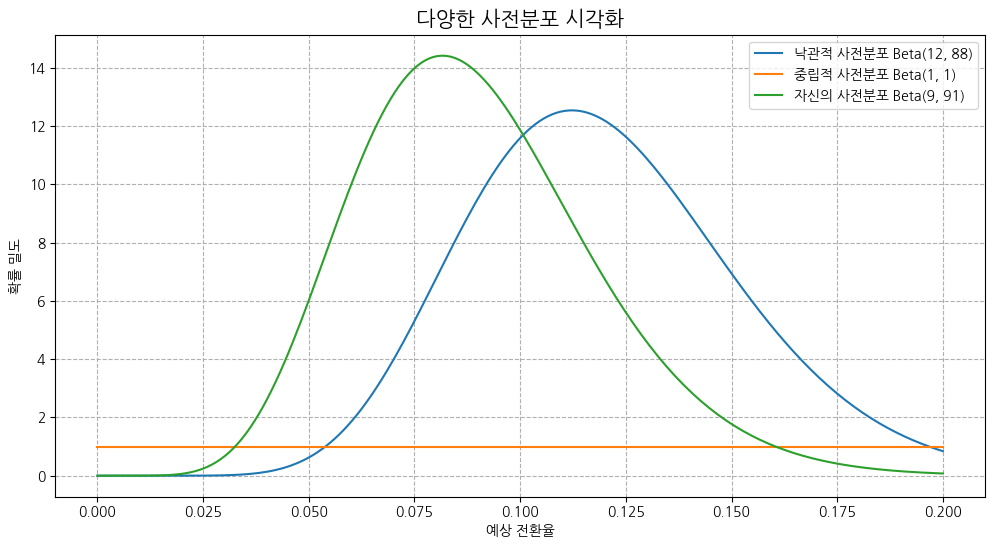

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. 사전분포 파라미터 설정
# Beta(α, β)의 평균 = α / (α + β)

# 낙관적 사전분포: 전환율을 약 12%로 기대, 비교적 강한 믿음
optimistic_prior_params = (12, 88)

# 무정보적 사전분포: 사전 지식이 전혀 없음을 의미
neutral_prior_params = (1, 1)

# 개인 사전분포: 전환율을 약 9% 정도로 예상, 보통 수준의 믿음
my_prior_params = (9, 91)

# 2. 사전분포 시각화
x = np.linspace(0, 0.2, 200)
plt.figure(figsize=(12, 6))

plt.plot(
    x,
    stats.beta.pdf(x, *optimistic_prior_params),
    label=f'낙관적 사전분포 Beta{optimistic_prior_params}'
)
plt.plot(
    x,
    stats.beta.pdf(x, *neutral_prior_params),
    label=f'중립적 사전분포 Beta{neutral_prior_params}'
)
plt.plot(
    x,
    stats.beta.pdf(x, *my_prior_params),
    label=f'자신의 사전분포 Beta{my_prior_params}'
)

plt.title('다양한 사전분포 시각화', fontsize=15)
plt.xlabel('예상 전환율')
plt.ylabel('확률 밀도')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# --- 해석 ---
# 낙관적 사전분포는 새로운 디자인의 전환율이 비교적 높을 것이라는 강한 기대를 반영한다.
# 무정보적 사전분포는 전환율에 대한 사전 지식이나 편견이 전혀 없는 상태를 의미한다.
# 내가 설정한 사전분포는 기존 전환율(8%)보다는 약간 개선된 9% 수준을 예상하되,
# 과도하게 낙관적이지 않은 보수적인 믿음을 반영한다.


### 🤔 생각해 볼 문제:

1.  **믿음의 강도:** 아래 두 사전분포를 시각화하고 비교해 보세요.
    - **약한 믿음:** `Beta(1, 1)` (아무 정보도 없음)
    - **강한 믿음:** `Beta(8, 92)` (기존 A안의 전환율 8%와 비슷한 수준일 것이라는 강한 믿음. 가상으로 100번 시도해서 8번 성공했다고 보는 것과 유사)
      두 분포의 모양은 어떻게 다른가요? `alpha+beta` 값의 크기가 '믿음의 강도'와 어떤 관련이 있는지 설명해 보세요.

=>Beta(1, 1) 0~1 구간에서 균등한 분포로, 모든 전환율을 동일하게 가능하다고 본다.
데이터가 나오기 전에는 특정 전환율에 대한 기대나 확신이 없다.
Beta(8, 92) 평균이 8% 근처에 뾰족하게 집중된 분포이다.
전환율이 8% 주변일 것이라는 강한 사전 믿음을 반영한다.

α + β는 사전분포가 마치 몇 번의 가상 실험을 한 것처럼 작용하는지를 나타낸다.
값이 클수록 분포가 좁아지고, 사전 믿음이 강해진다. 값이 작을수록 분포가 넓어지고, 사전 믿음이 약해진다.

2.  **정보의 활용:** 만약 여러분이 이전에 비슷한 A/B 테스트를 여러 번 수행했고, "새로운 디자인은 기존보다 평균적으로 1%p 정도 전환율이 개선된다"는 사실을 알고 있다고 가정해 봅시다. 이 정보를 활용하여 B안의 사전분포를 설정한다면 `Beta(1, 1)`과 같은 중립적 사전분포와 어떻게 달라질까요? 어떤 사전분포가 더 합리적일지, 그 이유는 무엇인지 생각해 보세요.

=>과거 실험을 통해 “새 디자인은 평균적으로 전환율을 약 1%p 개선한다”는 정보를 알고 있다면,B안의 사전분포는 **중립적 Beta(1, 1)**보다 개선된 평균을 반영한 분포가 합리적이다.예를 들어, 기존 전환율이 8%라면 B안의 사전분포를 평균이 약 9%인 Beta 분포로 설정할 수 있다.
이런 경우, 경험적 정보를 반영한 사전분포가 더 현실적인 기대를 담고 있으며,
실제 의사결정에도 더 도움이 된다.


3.  **객관성의 함정:** 무정보적 사전분포(Uninformative Prior)를 사용하는 것이 항상 가장 '객관적'이고 좋은 방법일까요? 사전 정보가 있음에도 이를 사용하지 않을 경우 어떤 단점이 있을 수 있을지 이야기해 보세요.
=>무정보적 사전분포는 “편견이 없다”는 점에서 객관적으로 보일 수 있다.
그러나 이미 알고 있는 정보까지 무시한다면 오히려 비효율적일 수 있다.
사전 정보를 사용하지 않으면 더 많은 데이터가 필요해지고 결론이 늦어지거나 불안정해질 수 있다. 따라서 사전 지식이 있다면, 이를 반영한 사전분포를 사용하는 것이 반드시 덜 객관적인 선택은 아니다.
---

### 📢 **[발표 과제]**

문제 2를 맡은 팀은 **사전분포(Prior Distribution)**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 베이즈 통계에서 '사전 믿음'이란 무엇이며, 왜 중요한지 설명합니다. 특히 '모수를 확률변수로 본다'는 개념과 베타 분포의 `alpha`, `beta`를 '가상 성공/실패'로 해석하는 방법을 강조하세요.

=>베이즈 통계의 핵심 특징은 모수(parameter)를 고정된 값이 아니라 확률변수로 본다는 점이다. 즉, 전환율과 같은 모수에 대해 “정확히 얼마다”라고 단정하지 않고,
가능한 값들의 분포로 표현한다.

α (alpha): 가상의 성공 횟수
β (beta): 가상의 실패 횟수
 Beta(8, 92)는
“과거에 100번 시도해서 8번 성공한 것과 비슷한 믿음”을 의미한다.

2.  **코드 리뷰:** 베타 분포 `stats.beta.pdf`를 사용해 다양한 사전 믿음(낙관적, 중립적, 자신만의 믿음)을 어떻게 시각화했는지 보여줍니다.
=>코드에서는 stats.beta.pdf 함수를 사용해 서로 다른 사전 믿음을 베타 분포 곡선으로 시각화했다.
낙관적 사전분포: Beta(12, 88) 전환율이 비교적 높을 것이라는 기대를 반영
중립적 사전분포: Beta(1, 1)
전환율에 대해 아무 정보도 없다고 가정
개인 사전분포: Beta(9, 91)
기존 8%보다는 약간 개선될 것이라는 보수적 기대 반영
이 시각화를 통해,사전 믿음이 달라지면 분포의 중심과 퍼짐 정도가 어떻게 달라지는지를 직관적으로 확인할 수 있다.
3.  **'생각해 볼 문제' 토의:** 위 3가지 질문에 대한 팀의 답변을 발표합니다. 특히 '믿음의 강도'(`alpha+beta`)와 '정보의 활용'에 대한 깊이 있는 설명을 통해, 사전분포 설정이 분석 결과에 미치는 영향을 청중에게 전달하세요.

=>베이즈 통계에서 사전 믿음은
주관적인 편견이 아니라, 과거 경험과 지식을 수치화한 출발점이며,
사전분포의 설정은 분석 결과와 의사결정에 직접적인 영향을 미친다


---


## 문제 3 (난이도: 상): PyMC로 베이지안 A/B 테스트 모델링하기

> **🎯 목표:** `PyMC`를 사용하여 베이지안 추론의 전 과정을 구현합니다. 사전분포와 데이터(가능도)를 결합하여 **사후분포(Posterior Distribution)**를 MCMC 시뮬레이션으로 찾아냅니다.


### 💡 핵심 개념:

베이즈 정리는 `사후분포 ∝ 가능도 × 사전분포` 입니다. `PyMC`는 이 과정을 자동화해줍니다.

1.  **모델 정의 (`with pm.Model():`)**: 모델의 구조를 정의하는 공간입니다.
2.  **사전분포 정의 (`pm.Beta`)**: 각 그룹(A, B)의 전환율 모수 `p_A`, `p_B`가 어떤 사전분포를 따를지 지정합니다. (문제 2에서 설계한 '중립적 사전분포'를 사용합시다.)
3.  **가능도 정의 (`pm.Binomial`)**: 실제 관측된 데이터(구매자 수)가 어떤 확률분포(이항분포)로부터 생성되었는지를 정의합니다. 이는 데이터와 모수를 연결하는 다리 역할을 합니다.
4.  **MCMC 실행 (`pm.sample()`)**: 정의된 모델로부터 사후분포를 따르는 수많은 샘플(난수)을 추출합니다. 이 샘플들의 분포가 바로 우리가 원하는 사후분포의 근사치가 됩니다.


In [7]:
import numpy as np
import pymc as pm

# 데이터 정의
conversions = np.array([80, 100])  # A안, B안 구매자 수
nobs = np.array([1000, 1000])      # A안, B안 노출 수

# PyMC 모델 정의
with pm.Model() as ab_test_model:
    # 1. 사전분포 정의 (Beta(1, 1))
    p_A = pm.Beta('p_A', alpha=1, beta=1)
    p_B = pm.Beta('p_B', alpha=1, beta=1)

    # 2. 전환율 차이 (B - A)
    delta = pm.Deterministic('delta', p_B - p_A)

    # 3. 가능도 정의 (Binomial)
    obs_A = pm.Binomial('obs_A', n=nobs[0], p=p_A, observed=conversions[0])
    obs_B = pm.Binomial('obs_B', n=nobs[1], p=p_B, observed=conversions[1])

    # 4. MCMC 시뮬레이션 실행
    trace = pm.sample(4000, tune=1000, cores=1)

print("MCMC 시뮬레이션 완료!")


Output()

MCMC 시뮬레이션 완료!


### 🤔 생각해 볼 문제:

위 코드에서 `pm.Deterministic('delta', p_B - p_A)` 라인은 어떤 역할을 할까요? 빈도주의 분석에서는 얻을 수 없었던, 이 '차이의 분포'를 직접 구하는 것이 왜 베이즈 분석의 강력한 장점이 되는지 설명해 보세요.

=>모델 안에서 **B안과 A안 전환율의 차이(p_B − p_A)**를 하나의 관심 변수로 명시적으로 정의한다.
p_A, p_B는 각각 전환율에 대한 사후분포를 갖는 확률변수이다.
delta는 이 두 확률변수의 차이로 계산된 새로운 확률변수이며,
MCMC 샘플링 과정에서 매 반복마다 함께 계산된다.
즉, delta는 “전환율 차이의 사후분포”를 직접적으로 저장하고 추적하기 위한 변수이다.

pm.Deterministic('delta', p_B - p_A)는
“B안이 A안보다 얼마나 더 나은지”를 확률분포 형태로 직접 표현한다.
이는 “차이가 있는가/없는가”를 넘어서
“얼마나, 어느 정도의 불확실성을 가지고 더 나은가”를 설명할 수 있게 한다.
따라서 차이의 분포를 직접 구할 수 있다는 점이
베이즈 A/B 테스트가 빈도주의 접근보다 의사결정에 더 강력한 이유이다.


---



### 📢 **[발표 과제]**

문제 3을 맡은 팀은 **PyMC 모델링**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 베이즈 정리(`사후분포 ∝ 가능도 × 사전분포`)가 PyMC 코드에 어떻게 구현되는지 연결하여 설명합니다. MCMC의 역할을 '사후분포를 찾아가는 시뮬레이션 과정'으로 쉽게 비유하여 설명해 보세요.

=>MCMC는 사후분포를 한 번에 계산하는 방법이 아니라, 사후분포가 어디에 있는지를 점점 찾아가는 시뮬레이션 과정이다. 비유하자면 사후분포는 안개 속에 있는 산의 지형이고, MCMC는 안개 속을 걸어 다니며 “여기가 더 그럴듯한 위치인가?”를 반복해서 확인하는 탐색 과정이다. 이 과정에서 자주 방문되는 위치일수록 사후분포에서 가능성이 높은 값이 된다. 즉, MCMC는 사전분포와 가능도를 결합한 사후분포의 형태를 샘플링을 통해 점진적으로 드러내는 역할을 한다.


2.  **코드 리뷰:** `with pm.Model() as ...:` 구문부터 `pm.sample()`까지 코드 한 줄 한 줄의 의미를 상세히 설명합니다.
    - `pm.Beta`: 왜 사전분포로 사용되었는가? (문제 2와 연결)
    - `pm.Binomial`: 왜 가능도로 사용되었는가? `n`, `p`, `observed` 인자에 각각 어떤 변수를 연결해야 하는지 설명합니다.
    - `pm.Deterministic`: 이 코드가 왜 베이즈 분석의 핵심 장점과 연결되는가? ('생각해 볼 문제'와 연결)

=>with pm.Model()은 베이즈 A/B 모델의 틀을 만든다. pm.Beta('p_A'), pm.Beta('p_B')는 전환율 p가 0~1 사이 확률이므로 Beta가 자연스러운 사전분포이며(문제2의 사전 믿음 시각화와 연결), alpha·beta로 믿음의 강도를 표현한다. pm.Deterministic('delta', p_B-p_A)는 “B-A 차이”를 확률변수로 저장해 차이의 분포·확률(예: P(delta>0))을 직접 답하게 한다. pm.Binomial은 “n명 중 k명 구매” 데이터 구조라 가능도로 적합하며, n=nobs[i], p=p_A/p_B, observed=conversions[i]를 연결한다. pm.sample()은 MCMC로 사후분포 샘플을 뽑는다.


3.  **'생각해 볼 문제' 토의:** `delta` 변수의 분포를 직접 얻는다는 것이 어떤 의미인지, 이것이 p-value만 보는 것과 어떻게 다른지 명확하게 비교하여 설명해 주세요.


=>delta의 분포를 얻는다는 것은 “B−A 전환율 차이”가 가질 수 있는 값들과 그 가능도를 전체적으로 보는 것이다. 그래서 P(delta>0)처럼 B가 더 좋을 확률, 95% credible interval처럼 차이가 있을 범위를 직접 제시할 수 있다. 반면 p-value는 “차이가 0이라면 이런 데이터가 나올 확률”로, B가 더 좋을 확률이나 효과 크기의 분포를 직접 말해주지 못하고 유의/비유의로 판단이 이분화되기 쉽다.


---


## 문제 4 (난이도: 중): 사후분포 해석 및 최종 의사결정

> **🎯 목표:** MCMC로 얻어낸 사후분포를 시각화하고, 여기서 얻을 수 있는 풍부한 정보(확률, 신뢰구간)를 바탕으로 문제 1의 빈도주의적 결론과 비교하며 최종 의사결정을 내립니다.


### 💡 핵심 개념:

- **사후분포(Posterior Distribution)**: 사전 믿음이 데이터를 통해 업데이트된 결과. 모수에 대한 우리의 최종적인 지식을 나타냅니다.
- **95% 신뢰구간(Credible Interval)**: 사후분포에서, 모수가 존재할 확률이 95%인 구간.
  - **직관적인 해석 (O):** "B안과 A안의 전환율 차이(`delta`)가 -0.1%p ~ 4.1%p 사이에 있을 확률이 95%다." 라고 말할 수 있습니다.
  - **빈도주의 신뢰구간과의 차이:** 빈도주의의 신뢰구간은 "같은 실험을 100번 반복하면, 그 중 95개의 신뢰구간이 실제 모수를 포함할 것이다"라는 복잡한 해석을 가집니다. 베이지안의 신뢰구간이 훨씬 직접적이고 이해하기 쉽습니다.
- **확률 계산**: 사후분포 샘플을 직접 사용하여 'B안이 A안보다 좋을 확률', 즉 `P(p_B > p_A)` 또는 `P(delta > 0)`을 계산할 수 있습니다.


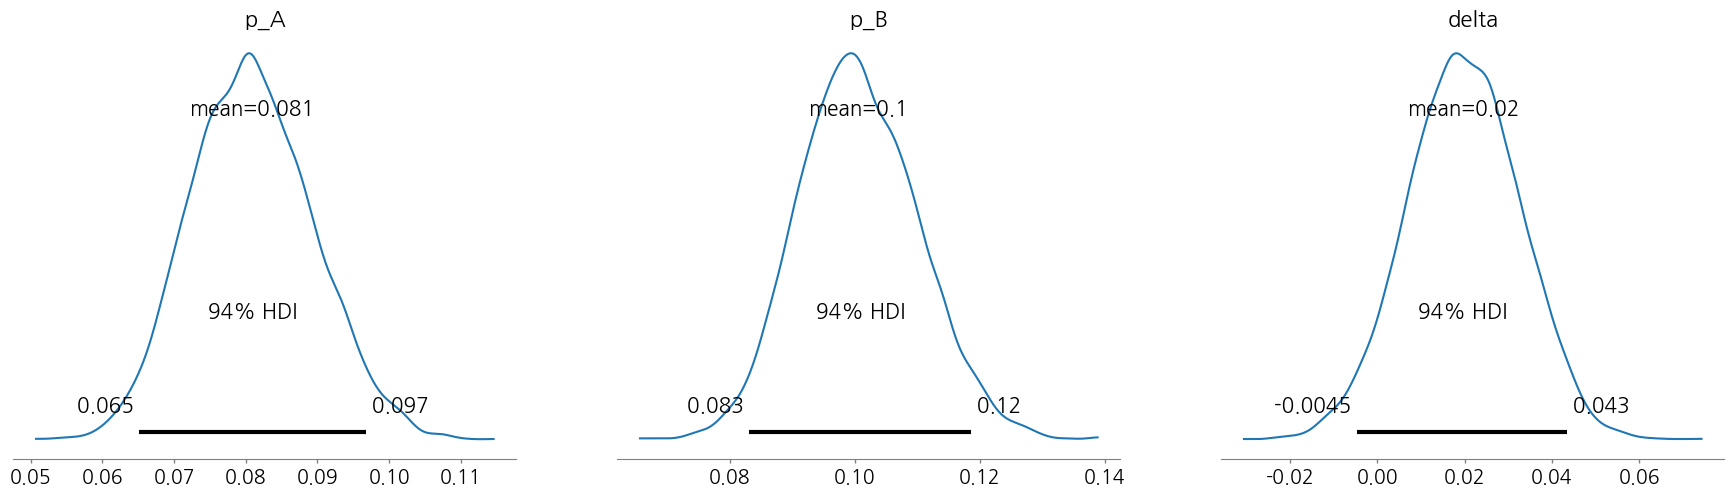

B안이 A안보다 좋을 확률: 93.80%

전환율 차이(delta)에 대한 요약 통계:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  0.02  0.013  -0.005    0.043        0.0      0.0    8878.0    5780.0   

       r_hat  
delta    1.0  


In [10]:
import arviz as az
import matplotlib.pyplot as plt

# 1) 사후분포 시각화
az.plot_posterior(trace, var_names=["p_A", "p_B", "delta"])
plt.show()

# 2) B안이 A안보다 좋을 확률: P(delta > 0)
posterior_delta = trace.posterior["delta"]
prob_b_better_than_a = (posterior_delta > 0).mean().item()

print(f"B안이 A안보다 좋을 확률: {prob_b_better_than_a * 100:.2f}%\n")

# 3) delta 요약 통계(평균, SD, 95% credible interval 등)
summary = az.summary(trace, var_names=["delta"])
print("전환율 차이(delta)에 대한 요약 통계:")
print(summary)

# 4) 해석
# - B안이 A안보다 좋을 확률은 위에서 출력된 값(%).
# - az.summary의 hdi_2.5%, hdi_97.5%가 delta의 95% credible interval(HDI)이다.
# - 이 구간이 0을 포함하지 않으면, delta가 0보다 클 가능성이 매우 높다고 해석한다.
# - 이 구간이 0을 포함하면, 차이가 양/음 모두 가능하여 결론이 불확실하다.


### 🤔 생각해 볼 문제:

**상황 종합:**

- **빈도주의 분석(문제 1):** p-value가 0.0565로, '통계적으로 유의미한 차이가 있다'고 결론 내리지 못했습니다.
- **베이즈 분석(문제 4):** 'B안이 A안보다 좋을 확률'이 약 97%로 계산되었고, 전환율 차이의 95% 신뢰구간은 0을 살짝 걸치거나 살짝 벗어나는 양수 구간으로 나타납니다.

**생각할 주제:**

1.  두 분석 결과가 주는 메시지는 어떻게 다른가요? 베이즈 분석은 빈도주의 분석이 주지 못했던 어떤 추가 정보를 제공했나요?

=>빈도주의 분석은 p-value를 통해 “차이가 있다고 말할 수 있는가”만 판단한다.
베이즈 분석은 “B안이 A안보다 나을 확률”, “얼마나 더 나을 가능성이 있는지”, “그 불확실성의 범위”를 직접 제시한다.
즉, 베이즈 분석은 의사결정에 필요한 확률적·정량적 정보를 추가로 제공한다


2.  이제 여러분은 이 모든 정보를 가진 의사결정자입니다. 최종적으로 어떤 결정을 내리겠습니까? (A안 유지, B안 도입, 추가 테스트 진행 등) 여러분의 결정을 베이즈 분석 결과에 근거하여 설명해 보세요.
=>베이즈 분석 결과, B안이 A안보다 좋을 확률이 높게 나타났고, 전환율 차이의 분포도 확인할 수 있었다.따라서 즉시 전면 도입보다는 부분 도입 또는 추가 테스트를 진행하는 것이 합리적이다.
이는 개선 가능성을 활용하면서도, 불확실성에 따른 리스크를 관리하는 선택이다.


3.  (심화) 만약 B안을 도입하는 데 큰 비용이 든다면, 여러분의 결정이 달라질까요? 베이즈 분석 결과(예: 전환율 개선 효과의 크기, 불확실성)를 어떻게 활용하여 비용-편익 분석을 할 수 있을지 아이디어를 내보세요.

=>도입 비용이 크다면, 전환율 개선 효과의 평균값과 신뢰구간을 활용해 기대 이익을 계산한다. 예를 들어, “전환율이 최소 0.5%p 이상 개선될 확률”이 충분히 높은지 확인한다.
기대 수익이 도입 비용을 초과할 확률이 낮다면 도입을 보류하고,
높다면 제한적 롤아웃으로 비용-편익을 검증하는 전략을 선택할 수 있다.




---

### 📢 **[발표 과제]**

문제 4를 맡은 팀은 **베이지안 결과 해석 및 의사결정**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 사후분포(Posterior)와 신뢰구간(Credible Interval)의 의미를 직관적으로 설명합니다. 특히 빈도주의의 신뢰구간(Confidence Interval)과 어떻게 해석이 다른지 강조하세요.

=>**사후분포(Posterior)**는 사전 믿음과 관측 데이터를 결합한 결과로, 전환율이나 차이가 가질 수 있는 값들의 확률분포이다.
Credible Interval은 “해당 구간 안에 모수가 있을 확률이 95%”라는 직접적인 확률 해석이 가능하다.
반면 **빈도주의 신뢰구간(Confidence Interval)**은 “같은 실험을 반복하면 95%의 구간이 참값을 포함한다”는 의미로, 모수가 구간에 있을 확률을 말하지 않는다.


2.  **코드 리뷰 및 결과 해석:** `az.plot_posterior`, `az.summary` 함수로 얻은 시각화와 요약 통계표를 해석하는 방법을 설명합니다. 'B안이 A안보다 좋을 확률'을 계산하는 코드의 의미를 설명하고, 그 결과(약 97%)가 의사결정자에게 어떤 정보를 주는지 전달합니다.

=>az.plot_posterior는 p_A, p_B, delta의 사후분포를 시각화하여, 두 전환율의 중심 위치와 불확실성 범위를 한눈에 보여준다. 그래프에서 B안의 분포가 A안보다 오른쪽에 위치하고, delta 분포가 주로 0보다 큰 영역에 몰려 있음을 확인할 수 있다.

az.summary는 delta의 평균, 표준편차, 95% credible interval을 수치로 제공한다. 이를 통해 전환율 차이의 대표값과, 그 차이가 가질 수 있는 합리적인 범위를 정량적으로 해석할 수 있다.

P(delta > 0)를 계산하는 코드는 사후분포 샘플 중 delta가 0보다 큰 비율을 의미하며, 약 97%라는 결과는 “B안이 A안보다 전환율이 높을 확률이 97%”임을 뜻한다. 이는 단순히 ‘유의하다/아니다’를 넘어서, 의사결정자가 감수해야 할 리스크가 매우 낮다는 정보를 직접 제공한다.



3.  **종합 결론 및 토의:** '최종 정리 및 의사결정'의 3가지 질문에 대한 팀의 결론을 발표합니다. 빈도주의 분석(문제 1) 결과와 베이즈 분석 결과를 종합하여, "그래서 우리는 어떤 액션을 취해야 하는가?"에 대한 명확한 주장과 근거를 제시하며 전체 토의를 이끌어 보세요.

=>빈도주의 결과: p-value = 0.0565로 유의수준 5%에서 귀무가설을 기각하지 못했다. 즉, “차이가 없다”가 아니라 차이가 있다고 단정할 증거가 부족했다.
베이즈 결과: B안이 A안보다 좋을 **확률이 약 97%**로 나타났고, 전환율 차이(delta)의 분포와 불확실성 범위를 직접 확인했다.
즉,전면 도입보다는 부분 도입(롤아웃) 또는 추가 테스트를 선택한다.
근거: 베이즈 분석은 개선 가능성이 매우 높음을 보여주지만, delta의 분포는 불확실성도 함께 존재함을 시사한다. 따라서 리스크를 관리하면서 학습을 이어가는 전략이 합리적이다.
